<div class="alert alert-block alert-warning">

# <p style="text-align: center;">Lab 4: Convolutional Neural Network (CNN)</p>
<div style="text-align: center;">
<img src="data/thumbnail.png" width="700"/>
</div>

Welcome to your fourth and final lab of ECE4179! Labs in this unit will run as a help desk and they are not mandatory to attend.

This notebook contains all the code and comments that you need to submit. Here are the instructions to complete this lab:

- Your grade is entirely based on notebook completion (no quiz).
- This lab requires training deep learning models with large datasets which takes a while to complete. You are **highly encouraged** to start as soon as possible.
- After completing the notebook, submit it to Moodle under '**Lab 4 Submission**'. Along with this notebook, you have to submit your model file for Task 2. Further instructions can be found in Task 2.
- IMPORTANT: The notebook will be auto-graded, therefore please do not edit/rename the already-given variable/function/class names.

This lab has two tasks:

- [Task 1: Design and train a CNN for image classification and analyse the results](#task1)
- [Task 2: Design and train a CNN by yourself](#task2)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(torch.__version__)  # Check PyTorch version
# print(torch.version.cuda)  # Check the CUDA version PyTorch was built with
# print(torch.cuda.is_available())  # Check if CUDA is available
# print(device)
# print(torch.cuda.device_count())  # Number of GPUs available
# print(torch.cuda.get_device_name(0))  # Name of the first GPU (if available)

def seed_all(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# if you intend to use GPU, you need to install PyTorch's CUDA support in the virtual environment:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# GPU will be slightly quicker for training, but this lab is tested and fully do-able with just cpu.

<div class="alert alert-block alert-info">

## Task 1 - Design and train a CNN for image classification <a class="anchor" id="task1"></a>
        
In Task 1, you will design a CNN for image classification task and train it on a given dataset. The procedure is similar to Lab 3's MLP, but this time we will be using convolutional layers.

<div style="text-align: center;">
<img src="data/task1.png" width="500" />
</div>

<div class="alert alert-block alert-info">

### 1.1 Create Pytorch Datasets and DataLoaders
     
The dataset for this set in located in `data/task1_train` and `data/task1_test`, which contains 6000 train images and 1250 test images (we will not have a validation set for simplicity). Each image has a resolution of 32 x 32 pixels and belongs to one of five classes (airplane, bird, cat, dog, ship).

In the same directory as this notebook, there are two csv files: `task1_train.csv` and `task1_test.csv`, which describes the dataset with the information "filename", "label", and "path". Have a look at these files and images to understand their structure.

In [177]:
# The classes are provided for you. You can run and utilise these variables in your code.
class_names = ['airplane', 'bird', 'cat', 'dog', 'ship']
num_class = len(class_names)

#### (a) Transforms & Data Augmentation

Image dataset usually undergoes transforms in the Dataset class, so we need to define them first. This concept is covered in the workshop, and [here](https://pytorch.org/vision/stable/transforms.html) is the PyTorch documentation about transforms.

The transforms we will use are mainly ("ToTensor()" and "Normalize()") which we have used in the workshop. Now in addition to the usual transforms, we will be adding __data augmentation__ as well. The ones we have included are:

- RandomHorizontalFlip()
- RandomRotation()

Now, what is **data augmentation**? Data augmentation in deep learning refers to the process of artificially diversifying a dataset by applying various transformations and modifications to the existing training examples. The objective of data augmentation is to enhance the model's generalization capability and robustness by exposing it to a wider range of variations and scenarios that might be encountered during real-world inference. These transformations can include rotations, flips, translations, changes in lighting and contrast, cropping, and more, depending on the nature of the data. By introducing this augmented data during training, the model becomes better equipped to handle novel and previously unseen examples, effectively reducing overfitting and improving its ability to extract meaningful features from noisy or imperfect inputs.

Data augmentation is specifically applied to the training set, and not the test set, because the purpose of data augmentation is to introduce diversity and variation into the training examples, helping the model to generalize better to real-world scenarios. The test set serves as an unbiased evaluation of the model's performance on unseen data. If data augmentation were applied to the test set, it could lead to overly optimistic performance estimates and potentially inflating its apparent accuracy.

In [178]:
# T1.1a IMPORTANT: Please do not edit/remove this comment.

# The Compose function allows you to combine multiple image transformations into a sequential pipeline. 
# Each transformation will be applied in the order they appear within the list.
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally (left to right)
    transforms.RandomRotation(degrees=10), # Apply a random rotation of +-10 degrees to each image
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalise the image tensor with mean and standard deviation values of 0.5 for each channel
])

# Augmentation is not applied to test data
transform_test = transforms.Compose([
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalise the image tensor with mean and standard deviation values of 0.5 for each channel
])

#### (b) Dataset class

Just like in the previous lab, we need a Dataset class first, which contains the three essential parts:
1. The \__init__ function <br>
2. The \__getitem__ function <br>
3. The \__len__ function

In [179]:
# T1.1b IMPORTANT: Please do not edit/remove this comment.

class Task1_Dataset(Dataset):
    def __init__(self, csv_file, class_names, transform=None):
        # In the previous lab, this part is where we load our data. However, if your datasest is very large,
        # you can't load all of them into memory at once, which is the case for this lab.
        # The strategy here is to load the file paths and labels (obtained from the csv file),
        # and load the images on-the-fly when __getitem__ is called by the DataLoader.
        
        self.df = pd.read_csv(csv_file) # Load the csv file as a pandas DataFrame (df for short)
        self.class_names = class_names
        self.transform = transform

    def __len__(self):
        # total number of samples is the same as the number of rows in the csv file
        return len(self.df)

    def __getitem__(self, idx):
        # We load the image and its label for the given index. The index is the row number in the csv file.
        # You should learn about how to access information from a pandas DataFrame.
        img_path = self.df.iloc[idx, 2]
        label = self.df.iloc[idx, 1]
        
        # Load image using PIL's Image.open() function for the given image path
        image = Image.open(img_path).convert('RGB')

        # Apply any transforms
        if self.transform:
            image = self.transform(image)

        return image, self.class_names.index(label) # image should be a tensor, label should be an integer

#### (c) Create Dataset instance from the defined Class and then the DataLoaders

Now that you've defined your dataset Class, lets create an instance of it for training and testing and then create dataloaders to make it easy to iterate.

In [180]:
# T1.1c IMPORTANT: Please do not edit/remove this comment.

bs_train = 64       # the batch size for training task 1
bs_test = 64        # the batch size for testing task 1

dataset_train = Task1_Dataset("task1_train.csv", class_names, transform=transform_train)
dataset_test = Task1_Dataset("task1_test.csv", class_names, transform=transform_test)
loader_train = DataLoader(dataset_train, bs_train, shuffle=True)
loader_test = DataLoader(dataset_test, bs_test, shuffle=False)

<div class="alert alert-block alert-info">

### 1.2 Design the CNN

You will design your CNN architecture according to the sequence given below. Write codes in the init function and forward function of the `Task1_CNN` class to implement the following forward pass:
    
| Sequence |    Layer Type     | channels | kernel size | stride | padding |  Input size   |  Output size  |
|:--------:|:---------------:  |----------|-------------|--------|---------|:-------------:|:-------------:|
|    1     |      Conv2D       | 16       | (3,3)       | 1      | 1       |  (03, 32, 32) |  (16, 32, 32) |
|    2     |       ReLU        |          |             |        |         |  (16, 32, 32) |  (16, 32, 32) |
|    3     |     MaxPool2d     |          | (2,2)       | 2      | 0       |  (16, 32, 32) |  (16, 16, 16) |            
|    4     |      Conv2D       | 32       | (3,3)       | 1      | 1       |  (16, 16, 16) |  (32, 16, 16) |    
|    5     |       ReLU        |          |             |        |         |  (32, 16, 16) |  (32, 16, 16) |
|    6     |     MaxPool2d     |          | (2,2)       | 2      | 0       |  (32, 16, 16) |  (32, 08, 08) |              
|    7     |      Conv2D       | 64       | (3,3)       | 1      | 1       |  (32, 08, 08) |  (64, 08, 08) | 
|    8     |       ReLU        |          |             |        |         |  (64, 08, 08) |  (64, 08, 08) | 
|    9     |     MaxPool2d     |          | (2,2)       | 2      | 0       |  (64, 08, 08) |  (64, 04, 04) |       
|   10     |      Flatten      |          |             |        |         |  (64, 08, 08) |  (1024, 0, 0) |
|   11     |       Linear      | ??       |             |        |         |  (?, ??, ??)  |  (?, ??, ??)  |

You should compute and fill in the sizes to ensure that you understand how the forward pass works.

For the other methods in the class, it will be similar to the previous lab. The difference is that we are doing **multiclass classification** instead of regression, so we shouldn't use MSE loss here. (What should be used?)

In [181]:
# T1.2 IMPORTANT: Please do not edit/remove this comment.

class Task1_CNN(nn.Module):
    
    def __init__(self, device='cpu'):

        super().__init__()
        self.device = device

        # Define layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten = nn.Flatten()
        self.fc      = nn.Linear(64 * 4 * 4, 5)

        self.to(device=self.device)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x
    
    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):

        self.loss_train_log = []
        self.loss_test_log = []
        self.best_loss = np.inf

        best_epoch = 0 
        
        # Define loss function
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.train() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
            
            # in every epoch, we will:
            # (1) loop over loader_train to train the model
            # (2) calculate the loss of training data and save it (for loss curve)
            # (3) calculate the loss of val/testing data and save it (for loss curve)
            # (4) print training progress
            # (5) early stopping

            # Step (1)        
            for x, y in loader_train:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # Reset the gradients
                optimizer.zero_grad()

                # Forward pass and calculate loss
                y_hat = self.forward(x)
                loss = loss_fn(y_hat, y)

                # Backward pass and update weights
                loss.backward()
                optimizer.step()

            # Step (2) (need to complete the self.evaluate function to work)
            loss_train = self.evaluate(loader_train)
            self.loss_train_log.append(loss_train)

            # Step (3) (need to complete the self.evaluate function to work)
            loss_test = self.evaluate(loader_test)
            self.loss_test_log.append(loss_test)

            # Step (4)
            if verbose:
                print('Epochs %d/%d' % (epoch+1, epochs))
                print('Train Loss = %.4f' % loss_train, end=', ')
                print('Test Loss = %.4f' % loss_test)

            # Step (5) save the best model (state_dict) as "task1_best_params.pt"
            if loss_test < self.best_loss:
                self.best_loss = loss_test
                best_epoch = epoch + 1
                torch.save(self.state_dict(), "task1_best_params.pt")
        
        print(f'Best model saved at epoch {best_epoch} with loss {self.best_loss:.4f}.')

    def evaluate(self, loader):
        # this function is to evaluate the model on a given dataset (loader) by computing the average loss

        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
        
        loss = 0
        loss_fn = nn.CrossEntropyLoss(reduction='sum')

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # forward pass and calculate loss
                yhat = self.forward(x)
                loss += loss_fn(yhat, y)
        
        loss /= len(loader.dataset)
        return loss.cpu()
    
    def predict(self, loader):
        # this function is to provide the model's prediction on a given dataset (loader).
        # it returns the prediction, together with the corresponding input x and label y (for evaluation/visualization purposes)
        
        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval

         # SOLUTION
        x_all, y_all, logit = [], [], []
        
        with torch.no_grad():

            for x, y in loader:

                x_all += [x]
                y_all += [y]
                x = x.to(device=self.device, dtype=torch.float)

                # forward pass and store predictions
                yhat = self.forward(x)
                logit.append(yhat.cpu())
            
            x_all, y_all, logit = torch.cat(x_all), torch.cat(y_all), torch.cat(logit)
            return x_all, y_all, logit

<div class="alert alert-block alert-info">

### 1.3 Train and evaluate the network  <a class="anchor" id="1_3"></a>

Now let's do some training for the network we just created! In this task, train our model using the following hyperparameters:
- Learning rate = 5e-3 (same as 0.005)
- Number of epochs = 10
- Optimizer = Adam

In [182]:
# T1.3 IMPORTANT: Please do not edit/remove this comment.

lr = 5e-3
epochs = 10
model = Task1_CNN(device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)
model.Train(epochs, optimizer, loader_train, loader_test)

Epochs 1/10
Train Loss = 1.0797, Test Loss = 1.1121
Epochs 2/10
Train Loss = 1.0501, Test Loss = 1.1034
Epochs 3/10
Train Loss = 0.9381, Test Loss = 1.0126
Epochs 4/10
Train Loss = 0.9260, Test Loss = 0.9995
Epochs 5/10
Train Loss = 0.8946, Test Loss = 0.9823
Epochs 6/10
Train Loss = 0.8619, Test Loss = 0.9641
Epochs 7/10
Train Loss = 0.8278, Test Loss = 0.9392
Epochs 8/10
Train Loss = 0.7868, Test Loss = 0.9344
Epochs 9/10
Train Loss = 0.7546, Test Loss = 0.9223
Epochs 10/10
Train Loss = 0.7614, Test Loss = 0.9495
Best model saved at epoch 9 with loss 0.9223.


<div class="alert alert-block alert-info">

### 1.4 Visualise and Analyse the Experimental Results <a class="anchor" id="1_4"></a>

Now the training is done. Let's check how well our model has performed.

There are a few ways we can evaluate the model performance:
- Inspect the loss
- Evaluate accuracy
- Precision, recall and F1-Score
- Confusion Matrix
And more

Let's try some of them here.

#### (a) Inspecting the loss

In the model class, there are two variables `self.loss_train_log` and `self.loss_test_log` which record the historical losses as the training progresses. Plot both the losses in the same figure to visualize the training progress, and ensure that proper labels and legend are in-place.

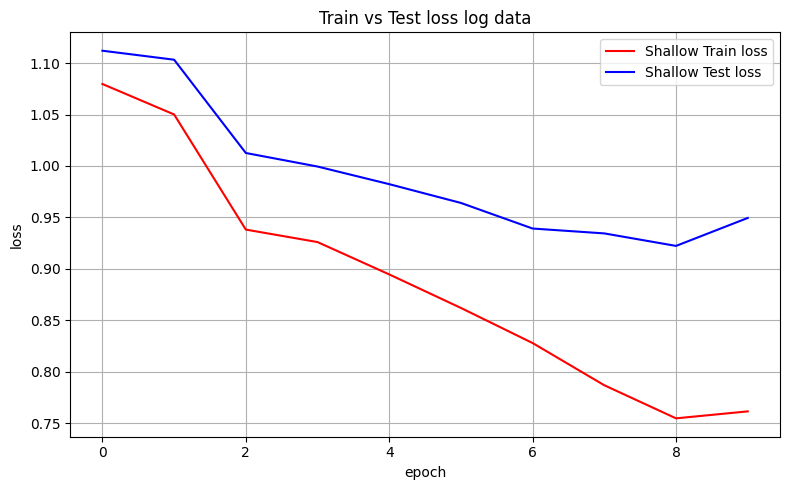

In [183]:
# T1.4a IMPORTANT: Please do not edit/remove this comment.

# Plot the losses in the same figure
plt.figure(figsize=(8, 5))

plt.plot(model.loss_train_log, color='red', label = 'Shallow Train loss')
plt.plot(model.loss_test_log, color='blue', label = 'Shallow Test loss')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Test loss log data")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

#### (b) Evaluate the classification accuracy

In a classification task, ultimately we want our model to make correct predictions. Using the values returned by the `predict` method, calculate the accuracy of your model, which is essentially the **fraction of correctly predicted classes** for all test data.

In [184]:
# This code loads the best model and calls the predict function for you, to be used in (b), (c), and (d).
best_params = torch.load('task1_best_params.pt')
model_best = Task1_CNN(device=device)
model_best.load_state_dict(best_params)
x_all, y_all, logit = model_best.predict(loader_test)

In [185]:
# T1.4b IMPORTANT: Please do not edit/remove this comment.

# To obtain the prediction classes from logit, you have to use softmax and then look for the class with the highest probability
predicted_classes = torch.argmax(F.softmax(logit, dim=1), dim=1)
accuracy = (predicted_classes == y_all).sum().item() / len(y_all)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6288


#### (c) Top (correctly) Classified Images


In this task, we find the top 5 correctly classified images for each of the classes from the test set and visualize them.

Top 5 correctly  classified - for e.g. take the 'airplane' class. First, find the test images that that were correctly predicted as 'airplane'. Out of those images, find out the predctions that got highest softmax scores and visualize them. Do this for all classes (you might want to use a for loop for this).   
    
In total, you have 5 classes, and 5 top correctly classified images for each class, hence you will have 25 images altogether. On top of each image, display its label, prediction, as well the the top softmax score as a percentage.
    
An example of an expected output for the Top Classified images for the "car" class are shown below (this example is a different dataset with higher resolution): 

<img src="./data/top-classified-demo.PNG" />


Top 5 correctly classified images for class: airplane


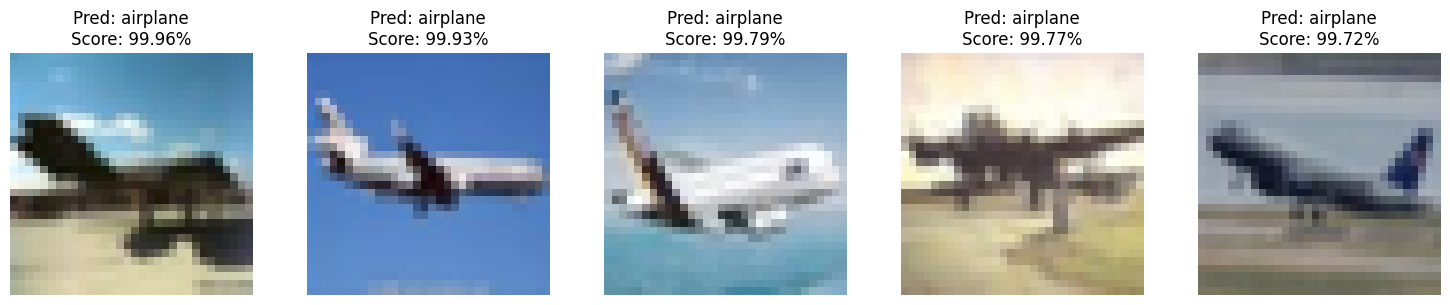

Top 5 correctly classified images for class: bird


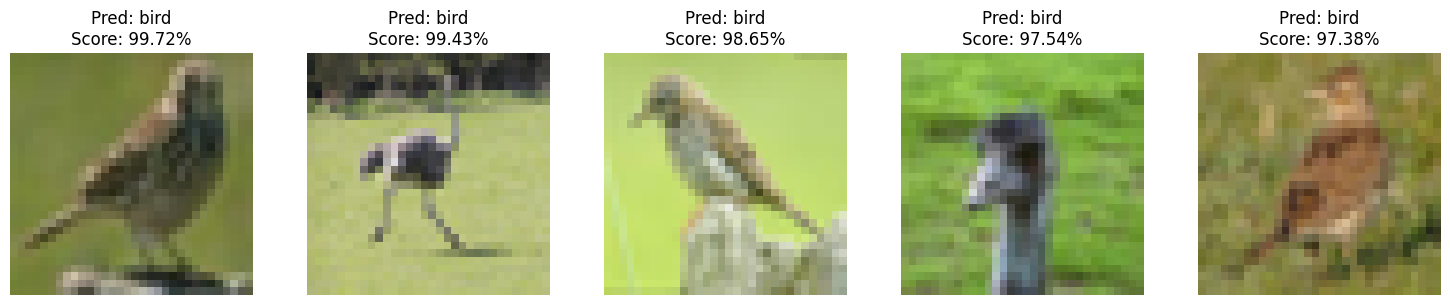

Top 5 correctly classified images for class: cat


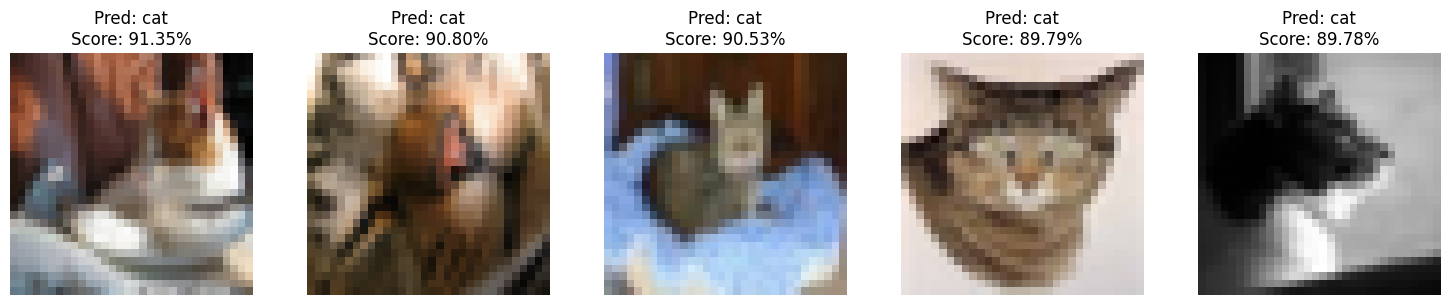

Top 5 correctly classified images for class: dog


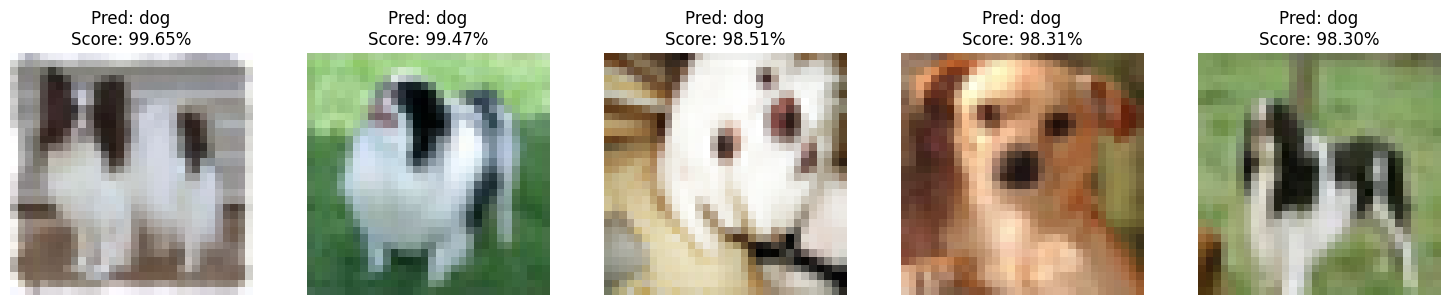

Top 5 correctly classified images for class: ship


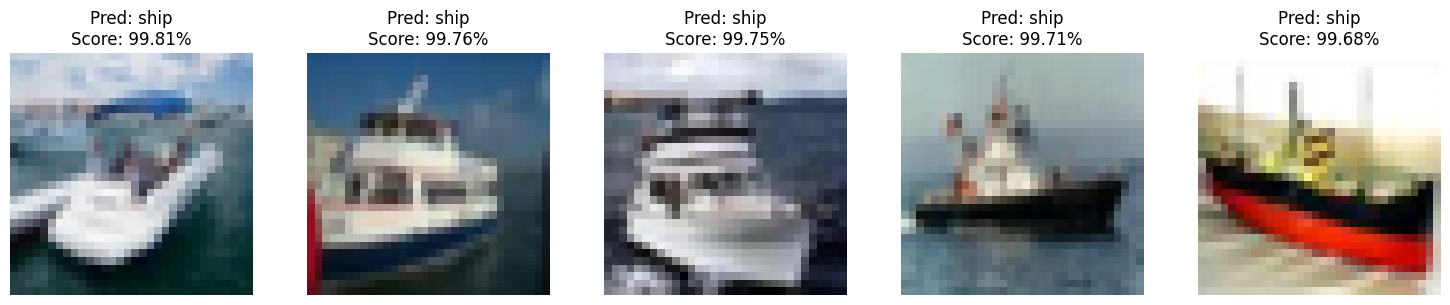

In [186]:
# T1.4c IMPORTANT: Please do not edit/remove this comment.

# Denormalization function
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

# Find the top 5 correctly classified images for each class
correct_indices = (predicted_classes == y_all).nonzero(as_tuple=True)[0]
softmax_scores = torch.softmax(logit, dim=1)  # Get softmax scores for all predictions

for class_idx, class_name in enumerate(class_names):
    # Filter correct predictions for the current class
    class_correct_indices = correct_indices[(y_all[correct_indices] == class_idx)]
    class_correct_scores = softmax_scores[class_correct_indices, class_idx]
    
    # Get top 5 highest scores
    top5_indices = class_correct_indices[class_correct_scores.argsort(descending=True)[:5]]
    
    # Print all top 5 images for the current class on one line
    print(f"Top 5 correctly classified images for class: {class_name}")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, idx in enumerate(top5_indices):
        # Denormalize the image
        image = denormalize(x_all[idx], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        axes[i].imshow(image.permute(1, 2, 0).clip(0, 1))  # Clip values to [0, 1] after denormalization
        axes[i].set_title(f"Pred: {class_names[predicted_classes[idx]]}\nScore: {softmax_scores[idx, predicted_classes[idx]]:.2%}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

#### (d) Top Misclassified Images

Here, we will do the opposite: find the top 5 misclassified images for each of the classes from the test set and visualize them.

- Top 5 Misclassified - for e.g. take the 'airplane' class. First, find the test images which were airplanes but were wrongly predicted as a different class. Out of those images, find out the 5 predictions that got highest softmax scores for the wrong class and visualize them. Do this for all classes (you might want to use a for loop for this as well).  
    
In total, you have 5 classes, and 5 top misclassified images for each class, hence you will have 25 images altogether. On top of each image, display its label, prediction, as well the the top softmax score as a percentage.
    
An example of an expected output for Top Missclassifed images for the "dog" class are shown below:  

<img src="./data/top-mis-classified-demo.PNG" />

Top 5 misclassified images for class: airplane


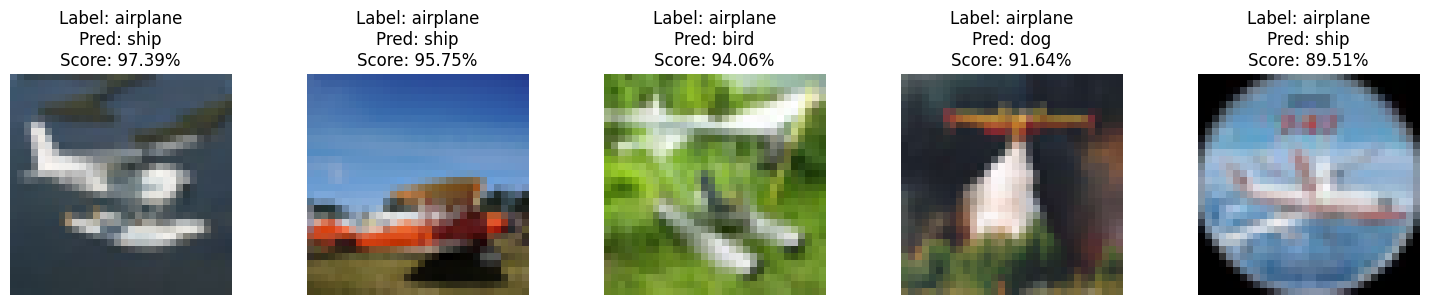

Top 5 misclassified images for class: bird


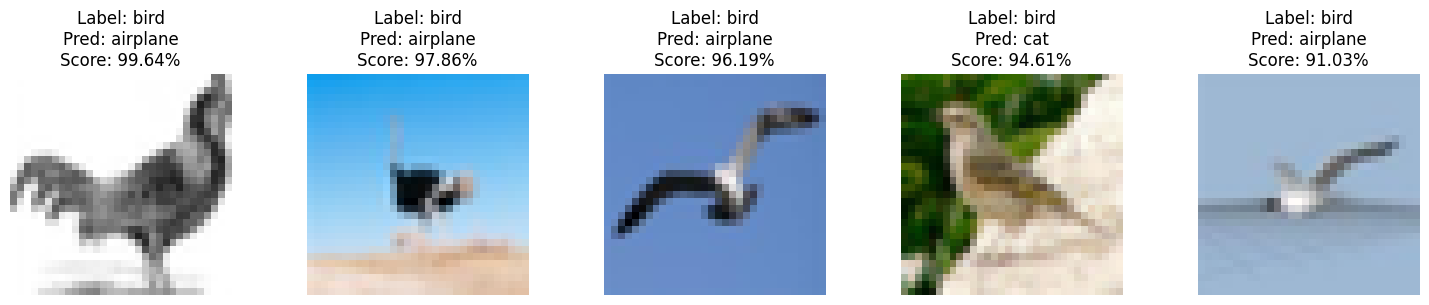

Top 5 misclassified images for class: cat


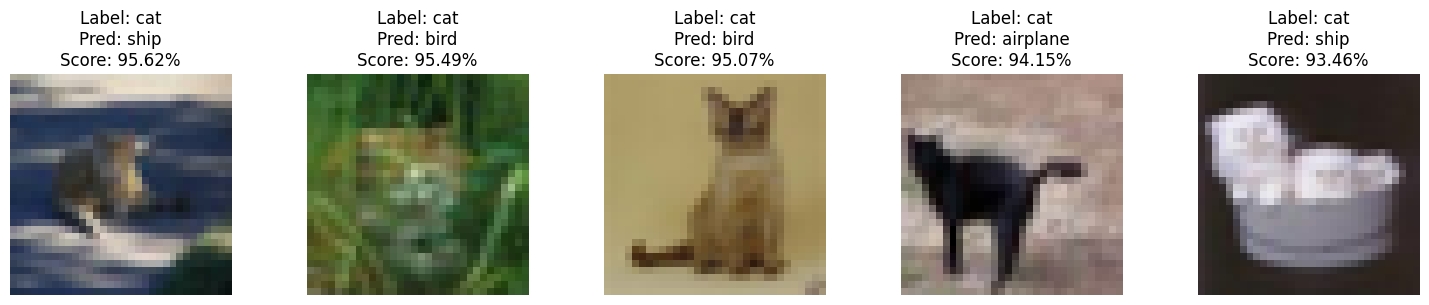

Top 5 misclassified images for class: dog


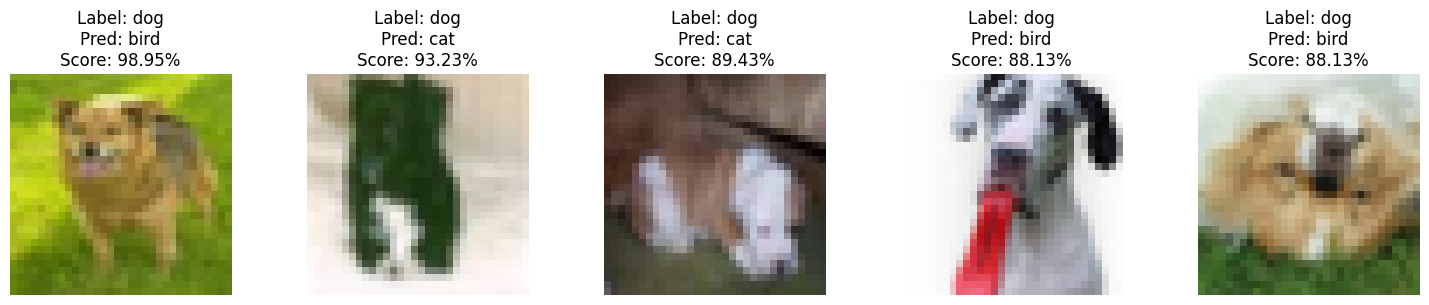

Top 5 misclassified images for class: ship


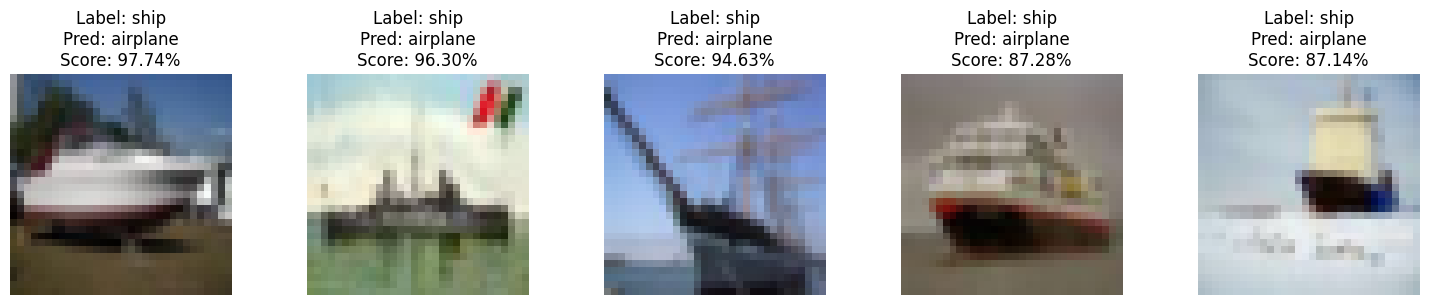

In [187]:
# T1.4d IMPORTANT: Please do not edit/remove this comment.

# Find the top 5 misclassified images for each class
incorrect_indices = (predicted_classes != y_all).nonzero(as_tuple=True)[0]
softmax_scores = torch.softmax(logit, dim=1)  # Get softmax scores for all predictions

for class_idx, class_name in enumerate(class_names):
    # Filter misclassified images where the true label is the current class
    class_incorrect_indices = incorrect_indices[(y_all[incorrect_indices] == class_idx)]
    class_incorrect_scores = softmax_scores[class_incorrect_indices, predicted_classes[class_incorrect_indices]]
    
    # Get top 5 highest scores for misclassified images
    top5_indices = class_incorrect_indices[class_incorrect_scores.argsort(descending=True)[:5]]
    
    # Print all top 5 images for the current class on one line
    print(f"Top 5 misclassified images for class: {class_name}")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, idx in enumerate(top5_indices):
        # Denormalize the image
        image = denormalize(x_all[idx], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        axes[i].imshow(image.permute(1, 2, 0).clip(0, 1))  # Clip values to [0, 1] after denormalization
        axes[i].set_title(f"Label: {class_names[y_all[idx]]}\nPred: {class_names[predicted_classes[idx]]}\nScore: {softmax_scores[idx, predicted_classes[idx]]:.2%}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-info">

## Task 2 - Design and train a CNN on your own <a class="anchor" id="task2"></a>
        
In this task, you will design and train a CNN for image classification using another dataset. The task is to classify images of facial expression into four different classes of emotions. There will be no guidance, and you should use the knowledge obtained thus far to complete this task.

The dataset that you will be using contains grayscale images with a resolution of 48x48 pixels. It is located in `data/task2_data`, and you are also provided with `task2_data.csv` similar to what you are given in Task 1. However, the dataset is not nicely partitioned for you in separate train-test folder. You would have to do it yourself, similar in a real-world setting where most problems don't come with a conveniently formatted dataset for you.

**READ** the following instructions carefully to understand how this task will be graded:

- You are free to design and explore whatever methods/layers/techniques you want.
- In the end, you are required to produce a model that you think is best, and named it as `task2_best_params.pt`. Use exactly this file name and there is no need to rename it.
- You will submit this `.pt` file, together with this notebook (`.ipynb`), in the Lab 4 Submission. Do **NOT** zip your submission.
- For grading, I will run your submitted model using a private test dataset (not given to you), and evaluate your model performance.
- In order to run your model, I have to instantiate your model class, i.e. `Task2_CNN`. Therefore, make sure all your model code are in this class, and in the cell commented with  "**# T2(model) ...**".
- As a check, there is a cell at the end of this task which you can run to make sure that your submission will be ok. In this cell, your best model will be used to run a few sample test images located in `data/task2_sample_test`. Make sure this cell can run without error before you submit the files.

Rubric for this task (worth 3%):

Your grade is based solely on your model’s performance on the private test data, according to the following criteria:
\begin{align*}
\text{Grade} = \begin{cases}
3\% & \text{Accuracy} \geq 0.75 \\
2.5\% & 0.7\leq\text{Accuracy} < 0.75 \\
2\% & 0.65\leq\text{Accuracy} < 0.7 \\
1.5\% & 0.6\leq\text{Accuracy} < 0.65 \\
1\% & \text{Accuracy} < 0.6 \\
0\% & \text{Code not able to run}
\end{cases}
\end{align*}

**[Bonus]**: The one with the highest accuracy will receive a bonus mark for the unit! 😄

Final notes:
- Your submitted model will be checked for similarity. If your model happens to have the same weight values with others, which is statistically impossible, it will be marked as plagiarism.
- If your training code (with your final hyperparameters) is run with the given dataset, the trained model should have similar performance to the one that you submit. If the difference is large, you will be questioned and asked to resubmit a new one in the presence of a demonstrator.

Good luck !

In [4]:
class_names = ['happy', 'surprise', 'neutral', 'sad']
num_class = len(class_names)

In [5]:
transform_miniX = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((48, 48)),
    transforms.ToTensor(),                        # Converts to shape [C, H, W]
])

MEAN, STD = 0.5, 0.5

transform_miniX_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(52),                                # extra border
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=.2, contrast=.2),   # works on grey tensors
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize([MEAN], [STD]),
])

transform_miniX_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[MEAN], std=[STD]),
])

# Augmentation is not applied to test data
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[MEAN], std=[STD]),
])

In [6]:
class Task2_Dataset(Dataset):
    def __init__(self, csv_file, class_names, transform=None):
        # In the previous lab, this part is where we load our data. However, if your datasest is very large,
        # you can't load all of them into memory at once, which is the case for this lab.
        # The strategy here is to load the file paths and labels (obtained from the csv file),
        # and load the images on-the-fly when __getitem__ is called by the DataLoader.
        
        self.df = pd.read_csv(csv_file) # Load the csv file as a pandas DataFrame (df for short)
        self.class_names = class_names
        self.transform = transform

    def __len__(self):
        # total number of samples is the same as the number of rows in the csv file
        return len(self.df)

    def __getitem__(self, idx):
        # We load the image and its label for the given index. The index is the row number in the csv file.
        # You should learn about how to access information from a pandas DataFrame.
        img_path = self.df.iloc[idx, 2]
        label = self.df.iloc[idx, 1]
        
        # Load image using PIL's Image.open() function for the given image path
        image = Image.open(img_path).convert('L')

        # Apply any transforms
        if self.transform:
            image = self.transform(image)

        label = label = torch.tensor(self.class_names.index(label), dtype=torch.long)
        return image, label

In [7]:
# T2(model) IMPORTANT: Please do not edit/remove this comment.
# Make sure this cell only has the model class. Other codes can go in new cells.

class Task2_CNN(nn.Module):

    # ---------------- hyper-params --------------- #
    PATIENCE_PLATEAU = 4            # ReduceLROnPlateau patience
    FACTOR           = 0.5          # LR shrink factor in Phase 1
    PATIENCE_SWITCH  = 10            # epochs of no improve → switch optimiser
    SGD_LR           = 3e-3         # initial LR for Phase 2
    SGD_TMAX         = 50           # cosine period; set to remaining epochs
    WEIGHT_DECAY     = 1e-4
    MIN_LR           = 1e-6         # floor for Phase 1
    # ---------------------------------------------- #
  
    def __init__(self, num_classes=4, device='cpu'):

        super().__init__()
        
        self.device = device

        #! TESTING
        self.to(device)
        self.device = device

        # function of one block of convolution layer for mini-Xception
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2)
            )
        
        # combined
        self.features = nn.Sequential(
            conv_block(1, 32),    # input: 1 x 48 x 48 → 32 x 24 x 24
            conv_block(32, 64),   # → 64 x 12 x 12
            conv_block(64, 128),  # → 128 x 6 x 6
            conv_block(128, 256)  # → 256 x 3 x 3
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                          # 256*3*3 = 2304
            nn.Linear(2304, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)            # ← Output layer to 4 classes
        )

        self.to(device=self.device)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def Train(self, epochs, optimizer, scheduler, loader_train, loader_test, verbose=True):

        self.loss_train_log = []
        self.loss_test_log = []
        self.acc_train_log = []
        self.acc_test_log = []

        self.best_loss = np.inf
        self.best_acc = 0

        best_epoch = 0 
        
        # Define loss function
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.train() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
            
            # in every epoch, we will:
            # (1) loop over loader_train to train the model
            # (2) calculate the loss of training data and save it (for loss curve)
            # (3) calculate the loss of val/testing data and save it (for loss curve)
            # (4) print training progress
            # (5) early stopping

            # Step (1)   
            for x, y in loader_train:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # Reset the gradients
                optimizer.zero_grad()

                # Forward pass and calculate loss
                y_hat = self.forward(x)
                loss = loss_fn(y_hat, y)

                # Backward pass and update weights
                loss.backward()
                optimizer.step()

            # Step (2) (need to complete the self.evaluate function to work)
            loss_train, acc_train = self.evaluate(loader_train)
            self.loss_train_log.append(loss_train)

            # Step (3) (need to complete the self.evaluate function to work)
            loss_test, acc_test = self.evaluate(loader_test)
            self.loss_test_log.append(loss_test)
            scheduler.step(acc_test)

            # Step (4)
            if verbose:
                print(f'Epochs %d/%d | LR = {optimizer.param_groups[0]['lr']:.6f}' % (epoch+1, epochs))
                print(f"Train Loss = {loss_train:.4f}, Train Acc = {acc_train:.2%} | Test Loss = {loss_test:.4f}, Test Acc = {acc_test:.2%}")
                # print('Train Loss = %.4f' % loss_train, end=', ')
                # print('Test Loss = %.4f' % loss_test)

            # Step (5) save the best model (state_dict) as "task1_best_params.pt"
            if acc_test > self.best_acc:
                self.best_loss = loss_test
                best_epoch = epoch + 1
                torch.save(self.state_dict(), "task2_best_params.pt")
        
        print(f'Best model saved at epoch {best_epoch} with loss {self.best_loss:.4f}.')

    def train_two_phase(
        self,
        model,
        loader_train,
        loader_val,
        max_epochs       = 100,
        plateau_patience = PATIENCE_PLATEAU,
        plateau_factor   = FACTOR,
        switch_patience  = PATIENCE_SWITCH,
        adam_lr          = 3e-4,
        sgd_lr           = SGD_LR,
        sgd_tmax         = SGD_TMAX,
        weight_decay     = WEIGHT_DECAY,
        min_lr           = MIN_LR,
        device           = "cuda" if torch.cuda.is_available() else "cpu"):

        model = model.to(device)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

        # ---------- Phase 1 ---------- #
        opt = optim.AdamW(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="max", factor=plateau_factor, patience=plateau_patience,
            threshold=1e-3, min_lr=min_lr
        )

        print(max_epochs)

        best_acc = 0.0
        epochs_no_improve = 0
        phase2 = False

        for epoch in range(max_epochs):
            # ―― training ―― #
            model.train()
            for x, y in loader_train:
                x, y = x.to(device), y.to(device)
                opt.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                opt.step()

            # ───────────── metrics via evaluate() ───────────── #
            train_loss, train_acc = self.evaluate(loader_train)   # <─ your helper
            val_loss,   val_acc   = self.evaluate(loader_val)     # <─ your helper

            # Phase-specific scheduler step
            if not phase2:
                sched.step(val_acc)
            else:
                sched.step()

            # ―― logging ―― #
            lr_now = opt.param_groups[0]['lr']
            lr_now = opt.param_groups[0]['lr']
            print(f"[{epoch:03}] lr {lr_now:.2e} | "
                f"train {train_loss:.4f}/{train_acc:.2%}  "
                f"val {val_loss:.4f}/{val_acc:.2%}")

            # ―― checkpoint / early-stop bookkeeping ―― #
            improved = val_acc > best_acc + 1e-3
            if improved:
                best_acc = val_acc
                # epochs_no_improve = 0
                torch.save(model.state_dict(), "task2_best_params.pt")
            else:
                epochs_no_improve += 1

            # ―― switch criterion ―― #
            if (not phase2
                and opt.param_groups[0]['lr'] <= 2e-5  # LR has bottomed once
                and epochs_no_improve >= switch_patience):

                print(f"\n>>> Plateau confirmed at epoch {epoch}.  "
                    "Switching to SGD + CosineAnnealing.\n")

                opt = optim.SGD(model.parameters(), lr=sgd_lr,
                                momentum=0.9, weight_decay=weight_decay,
                                nesterov=True)
                sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=sgd_tmax, eta_min=min_lr)
                phase2 = True
                epochs_no_improve = 0        # reset patience counter
                # (optional) reload the best checkpoint so far
                model.load_state_dict(torch.load("task2_best_params.pt"))

            # ―― hard early-stop if Phase 2 also plateaus ―― #
            if phase2 and epochs_no_improve >= 20:
                print("Early-stopping – Phase 2 plateau.")
                break

        print(f"Finished.  Best val_acc = {best_acc:.4f}")
        model.load_state_dict(torch.load("task2_best_params.pt"))

    def evaluate(self, loader):
        # this function is to evaluate the model on a given dataset (loader) by computing the average loss

        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
        
        loss = 0
        loss_fn = nn.CrossEntropyLoss(reduction='sum')

        accuracy = 0

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # forward pass and calculate loss
                yhat = self.forward(x)
                loss += loss_fn(yhat, y)

                preds = torch.argmax(yhat, dim=1)
                accuracy += (preds == y).sum().item()
            
        loss /= len(loader.dataset)
        accuracy /= len(loader.dataset)
        return loss.cpu(), accuracy
    
    def predict(self, loader):
        # this function is to provide the model's prediction on a given dataset (loader).
        # it returns the prediction, together with the corresponding input x and label y (for evaluation/visualization purposes)
        
        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval

         # SOLUTION
        x_all, y_all, logit = [], [], []

        #! edited
        # filenames_all = []
        
        with torch.no_grad():

            for x, y in loader:

                x_all += [x]
                y_all += [y]
                x = x.to(device=self.device, dtype=torch.float)

                #! edited
                # filenames_all.extend(paths)  # <-- collect filenames

                # forward pass and store predictions
                yhat = self.forward(x)
                logit.append(yhat.cpu())
            
            x_all, y_all, logit = torch.cat(x_all), torch.cat(y_all), torch.cat(logit)

            #! edited
            return x_all, y_all, logit

In [8]:
#* Dataloaders
dataset_t2_train = Task2_Dataset('new_train.csv', class_names, transform=transform_miniX_train)
dataset_t2_test = Task2_Dataset('new_test.csv', class_names, transform=transform_miniX_test)
loader_t2_train = DataLoader(dataset_t2_train, batch_size=4, shuffle=False)
loader_t2_test = DataLoader(dataset_t2_test, batch_size=4, shuffle=False)

In [294]:
# Scratch training
model_miniX = Task2_CNN(device=device)

#* -------------------- Training --------------------------#
# lr = 3e-4
# epochs = 100
# optimizer = optim.Adam(model_miniX.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode="max",          # you want accuracy to go ↑
#     factor=0.1,          # typical value; 0.3 is mild
#     patience=2,          # give it a chance to improve
#     threshold=1e-3,      # don’t fire for noise
# )
# model_miniX.Train(epochs, optimizer, scheduler, loader_t2_train, loader_t2_test)

#* -------------------- Training NEW -----------------------#
model_miniX.train_two_phase(
    model_miniX,
    loader_t2_train,
    loader_t2_test,
    max_epochs=500,   # hard cap; early-stop will cut sooner
    sgd_tmax=50       # cosine period for phase-2
)
#* -------------------- -------- --------------------------#

500
[000] lr 3.00e-04 | train 1.2621/39.06%  val 1.2304/39.75%
[001] lr 3.00e-04 | train 1.1529/46.09%  val 1.0993/48.50%
[002] lr 3.00e-04 | train 0.9906/55.94%  val 0.9232/58.45%
[003] lr 3.00e-04 | train 0.9364/58.62%  val 0.8922/59.05%
[004] lr 3.00e-04 | train 0.8582/63.56%  val 0.8186/63.90%
[005] lr 3.00e-04 | train 0.8022/66.96%  val 0.7909/66.25%
[006] lr 3.00e-04 | train 0.7863/68.64%  val 0.7731/67.55%
[007] lr 3.00e-04 | train 0.7673/68.01%  val 0.7811/66.25%
[008] lr 3.00e-04 | train 0.7561/69.66%  val 0.7655/67.80%
[009] lr 3.00e-04 | train 0.7309/70.98%  val 0.7350/69.95%
[010] lr 3.00e-04 | train 0.7163/72.11%  val 0.7493/69.45%
[011] lr 3.00e-04 | train 0.6928/73.11%  val 0.7244/69.90%
[012] lr 3.00e-04 | train 0.6872/73.05%  val 0.7231/70.05%
[013] lr 3.00e-04 | train 0.6864/73.13%  val 0.7316/69.60%
[014] lr 3.00e-04 | train 0.6576/74.38%  val 0.7215/69.50%
[015] lr 3.00e-04 | train 0.6369/76.57%  val 0.6753/73.10%
[016] lr 3.00e-04 | train 0.6261/76.15%  val 0.6900/

In [9]:
# Accuracy for Mini-Xception only
best_params = torch.load('task2_best_params.pt')
model_best = Task2_CNN(device=device)
model_best.load_state_dict(best_params)
dataset_sample_test = Task2_Dataset('task2_sample_test.csv', class_names, transform=transform_test)
loader_sample_test = DataLoader(dataset_sample_test, batch_size=4, shuffle=False)


x_all, y_all, logit = model_best.predict(loader_sample_test)
predicted_classes = torch.argmax(F.softmax(logit, dim=1), dim=1)
accuracy = (predicted_classes == y_all).sum().item() / len(y_all)
print(f'Accuracy: {accuracy:.4f}')
probabilities = F.softmax(logit, dim=1)

_, y_all, logit = model_best.predict(loader_sample_test)
print(f'y_all is {y_all} with shape: {y_all.shape}') # should be tensor([0, 1, 2, 3]) with shape torch.Size([4])
print(f'logit is {probabilities} with shape: {probabilities.shape}') # should be tensor(<bunch of logits>) with shape torch.Size([4, 4])

Accuracy: 1.0000
y_all is tensor([0, 1, 2, 3]) with shape: torch.Size([4])
logit is tensor([[0.9448, 0.0127, 0.0235, 0.0190],
        [0.0814, 0.7763, 0.0588, 0.0834],
        [0.0568, 0.0122, 0.6397, 0.2914],
        [0.0094, 0.0084, 0.0575, 0.9248]]) with shape: torch.Size([4, 4])


Top 5 correctly classified images for class: happy


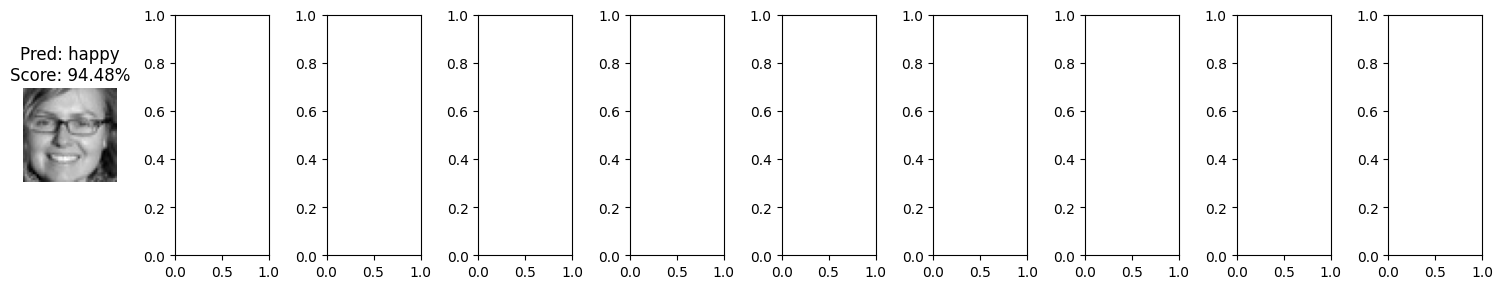

Top 5 correctly classified images for class: surprise


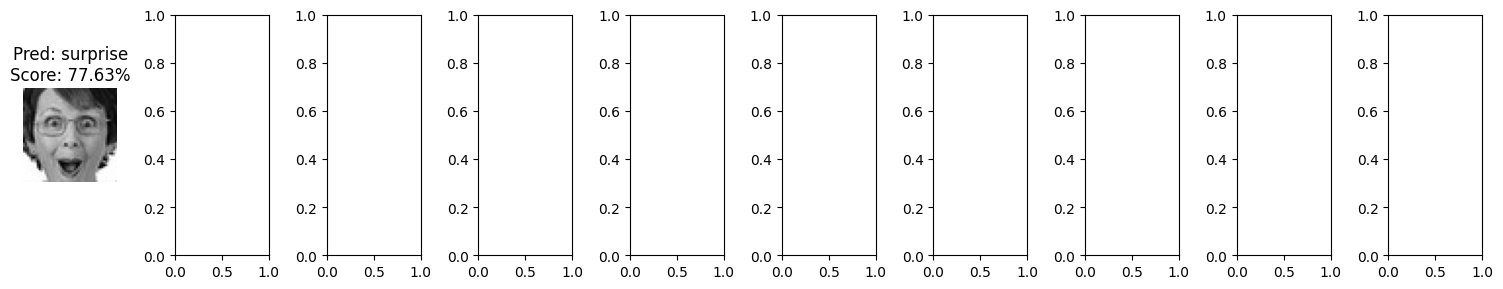

Top 5 correctly classified images for class: neutral


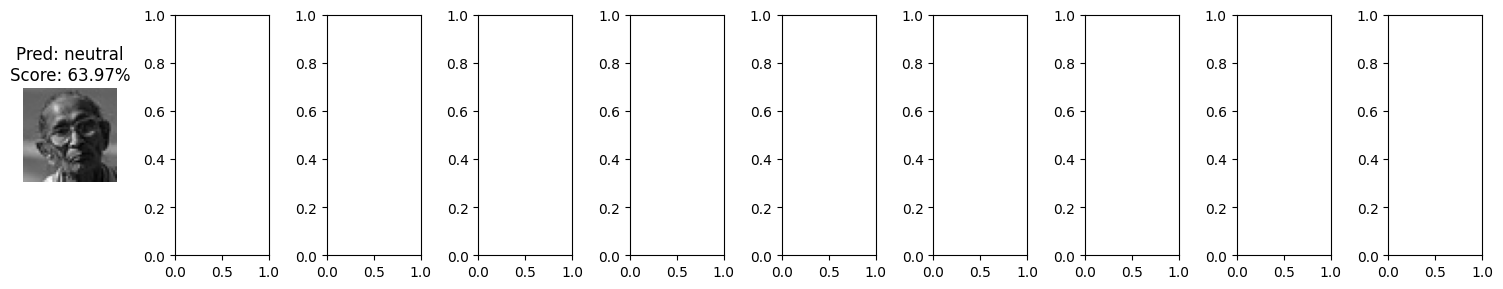

Top 5 correctly classified images for class: sad


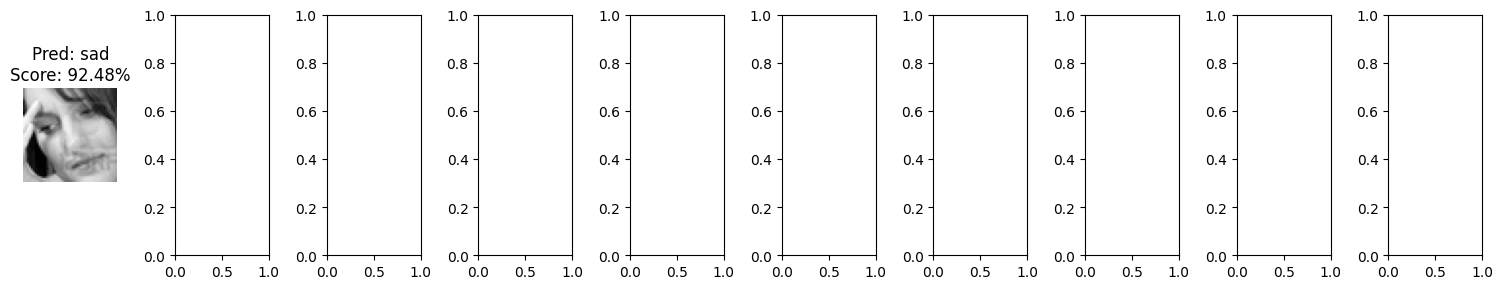

In [11]:
#* TOP 10 correct
top_k = 10
# Denormalization function
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(1, 1, 1)
    std = torch.tensor(std).view(1, 1, 1)
    return image * std + mean

# Find the top 5 correctly classified images for each class
correct_indices = (predicted_classes == y_all).nonzero(as_tuple=True)[0]
softmax_scores = torch.softmax(logit, dim=1)  # Get softmax scores for all predictions

for class_idx, class_name in enumerate(class_names):
    # Filter correct predictions for the current class
    class_correct_indices = correct_indices[(y_all[correct_indices] == class_idx)]
    class_correct_scores = softmax_scores[class_correct_indices, class_idx]
    
    # Get top 5 highest scores
    top5_indices = class_correct_indices[class_correct_scores.argsort(descending=True)[:top_k]]
    
    # Print all top 5 images for the current class on one line
    print(f"Top 5 correctly classified images for class: {class_name}")
    fig, axes = plt.subplots(1, top_k, figsize=(15, 3))
    for i, idx in enumerate(top5_indices):
        # Denormalize the image
        image = denormalize(x_all[idx], mean=[0.5], std=[0.5])
        axes[i].imshow(image.squeeze(0).clip(0, 1), cmap='gray')
        axes[i].set_title(f"Pred: {class_names[predicted_classes[idx]]}\nScore: {softmax_scores[idx, predicted_classes[idx]]:.2%}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

Top 5 misclassified images for class: happy


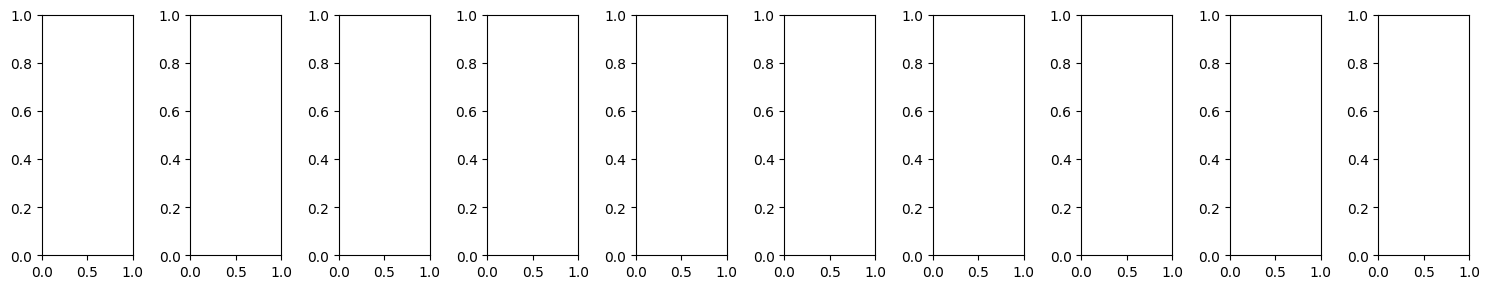

Top 5 misclassified images for class: surprise


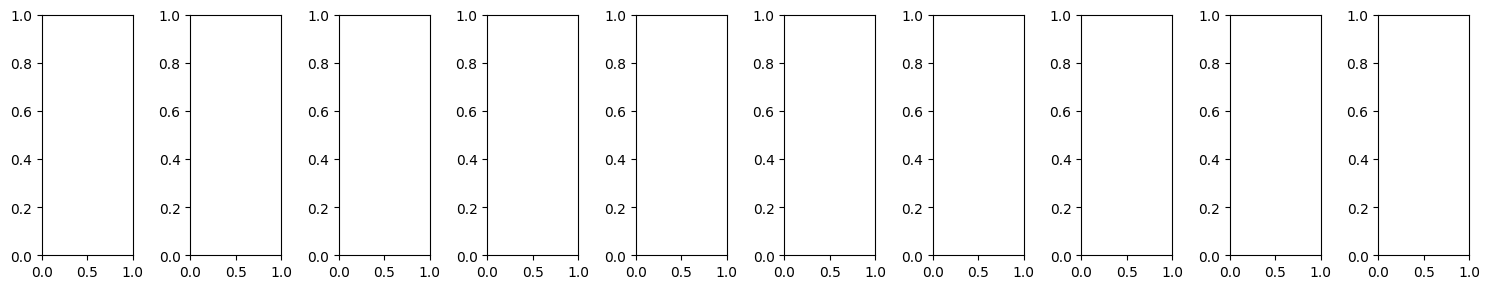

Top 5 misclassified images for class: neutral


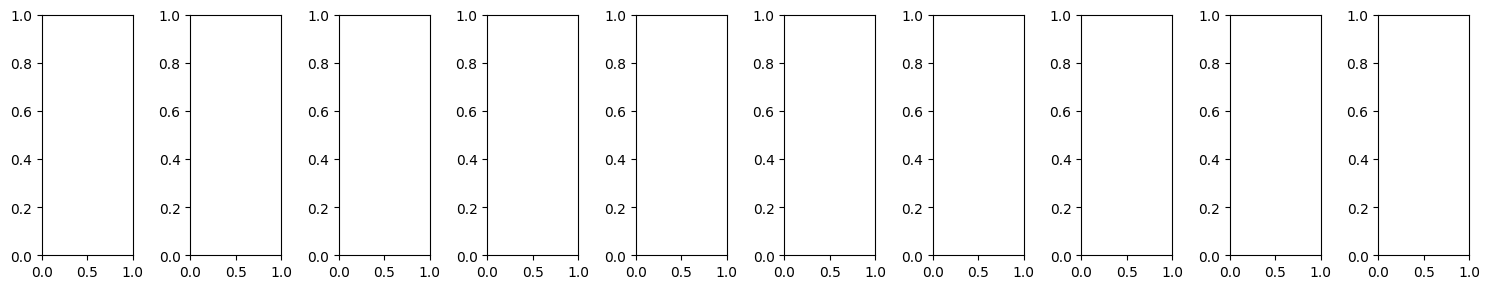

Top 5 misclassified images for class: sad


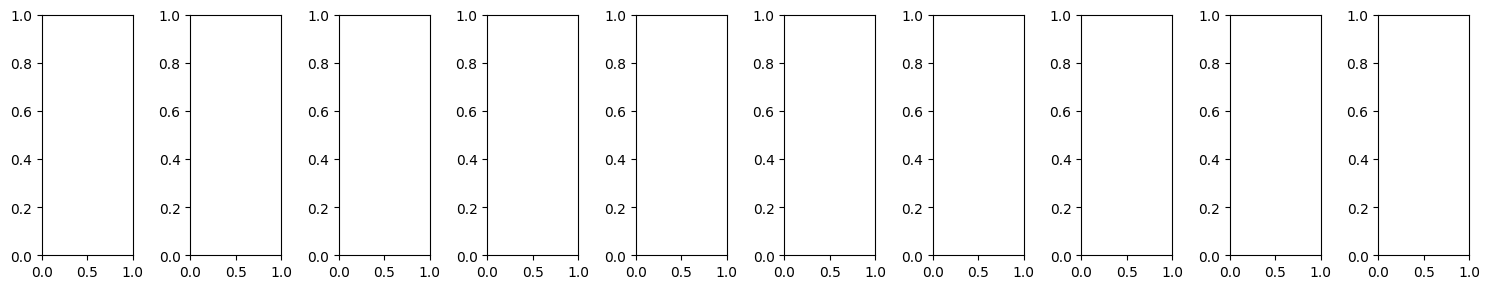

In [12]:
# T1.4d TOP 10 wrong
top_k = 10

# Find the top 5 misclassified images for each class
incorrect_indices = (predicted_classes != y_all).nonzero(as_tuple=True)[0]
softmax_scores = torch.softmax(logit, dim=1)  # Get softmax scores for all predictions

for class_idx, class_name in enumerate(class_names):
    # Filter misclassified images where the true label is the current class
    class_incorrect_indices = incorrect_indices[(y_all[incorrect_indices] == class_idx)]
    class_incorrect_scores = softmax_scores[class_incorrect_indices, predicted_classes[class_incorrect_indices]]
    
    # Get top 5 highest scores for misclassified images
    top5_indices = class_incorrect_indices[class_incorrect_scores.argsort(descending=True)[:top_k]]
    
    # Print all top 5 images for the current class on one line
    print(f"Top 5 misclassified images for class: {class_name}")
    fig, axes = plt.subplots(1, top_k, figsize=(15, 3))
    for i, idx in enumerate(top5_indices):
        # Denormalize the image
        image = denormalize(x_all[idx], mean=[0.5], std=[0.5])
        axes[i].imshow(image.squeeze(0).clip(0, 1), cmap='gray')
        axes[i].set_title(f"Label: {class_names[y_all[idx]]}\nPred: {class_names[predicted_classes[idx]]}\nScore: {softmax_scores[idx, predicted_classes[idx]]:.2%}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [251]:
# Accuracy for Resent + Mini-Xception
best_params = torch.load("teacher.pt", map_location=device)
model_best = ResNet18_GRAY(num_classes=4, device=device)  # ensure num_classes
model_best.load_state_dict(best_params)
x_all, y_all, logit = model_best.predict(loader_t2_test)

# To obtain the prediction classes from logit, you have to use softmax and then look for the class with the highest probability
predicted_classes = torch.argmax(F.softmax(logit, dim=1), dim=1)
accuracy = (predicted_classes == y_all).sum().item() / len(y_all)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7210


In [16]:
# For Task 2 to be graded, make sure this cell can run without error and without modification
# You have to define and run your Task2_Dataset first

dataset_sample_test = Task2_Dataset('task2_sample_test.csv', class_names, transform=transform_test)
loader_sample_test = DataLoader(dataset_sample_test, batch_size=4, shuffle=False)

task2_best_params = torch.load('task2_best_params.pt')
model_best = Task2_CNN(device=device)
model_best.load_state_dict(task2_best_params)
_, y_all, logit = model_best.predict(loader_sample_test)
print(f'y_all is {y_all} with shape: {y_all.shape}') # should be tensor([0, 1, 2, 3]) with shape torch.Size([4])
print(f'logit is {logit} with shape: {logit.shape}') # should be tensor(<bunch of logits>) with shape torch.Size([4, 4])

y_all is tensor([0, 1, 2, 3]) with shape: torch.Size([4])
logit is tensor([[ 2.7019, -1.6098, -0.9913, -1.2034],
        [-0.5574,  1.6973, -0.8828, -0.5331],
        [-1.0583, -2.6007,  1.3629,  0.5765],
        [-1.9349, -2.0543, -0.1255,  2.6526]]) with shape: torch.Size([4, 4])
